# Scratchpad
A place to randomly test code without having to worry how to organize it.

## Python dictionaries with new NetworkBuilder modularization

In [5]:
def create_op(input_op, op_dict):
    op_type = op_dict["type"]
    if op_type.lower() == "gather_nd":
        return gather_nd(*input_op, **op_dict["kwargs"])
    else:
        raise ValueError("Operation type \"" + op_type + "\" not yet defined.")

def gather_nd(params,
              indices,
              name="gather_nd"):
    print(name)
    return params, indices

In [9]:
input_op = []
op_dict = {"input": [],
           "type": "gather_nd",
           "kwargs": {
               "params": 5,
               "indices": 3,
               "name": "test"
           }}
input_op = op_dict["input"]
print(create_op(input_op, op_dict))

test
(5, 3)


In [14]:
test_dict = {5: "yes",
             4: 3}
for k, v in op_dict["kwargs"].items():
    if v in test_dict: print(v)

5


In [1]:
import os
os.chdir("../python/")
import json

In [2]:
def recursive_dict_search(dictionary, key, old_value, new_value):
    """
    Replaces all key-old_value pairs with key-new_value pairs in dictionary.
    
    Args:
    - d: Dictionary to be modified.
    - key: Initial key.
    - old_value: Value to be replaced.
    - new_value: Value to replace old_value.
    """
    _recursive_dict_search(dictionary, dictionary, key, old_value, new_value)

def _recursive_dict_search(init_d, d, keys, old_val, new_val):
    # If dictionary, continue to explore all key-value pairs
    if isinstance(d, dict):
        for k, v in zip(d.keys(), d.values()):
            keys.append(k)
            _recursive_dict_search(init_d, v, keys, old_val, new_val)
        if len(keys) > 0: # avoids error at end
            keys.pop()
    
    # If list, then value list iterated through for all items
    elif isinstance(d, list):
        d = _recursive_list_search(d, old_val, new_val)
        t = init_d 
        for key in keys[:-1]:
            t = t[key]
        t[keys[-1]] = d
        keys.pop()
    
    # Otherwise, then replace old value with new value
    else:
        if d == old_val:
            t = init_d 
            for key in keys[:-1]:
                t = t[key]
            t[keys[-1]] = new_val
        keys.pop()

def _recursive_list_search(l, old_val, new_val):
    if isinstance(l, list):
        t = []
        for l_ in l:
            v = _recursive_list_search(l_, old_val, new_val)
            t.append(v)
        return t
    elif isinstance(l, dict):
        recursive_dict_search(l, [], old_val, new_val)
        return l
    else:
        if l == old_val:
            l = new_val
        return l

In [4]:
agent_file = "../networks/test.json"
agent = json.loads(open(agent_file).read())
print(agent)
recursive_dict_search(agent, [], "None", None)
print(agent)

{'global_features': {'type': 'custom'}, 'placeholders': [{'name': 'screen', 'data_type': 'float32', 'kwargs': {'shape': ['None', 1, 45, 120], 'name': 'screen'}}, {'name': 'health', 'data_type': 'float32', 'kwargs': {'shape': ['None', 2], 'name': 'health'}}, {'name': 'target_Q', 'data_type': 'float32', 'kwargs': {'shape': ['None', 8], 'name': 'target_Q'}}, {'name': 'action', 'data_type': 'int32', 'kwargs': {'shape': ['None', 1], 'name': 'action'}}], 'layers': [{'name': 'CONV_1', 'type': 'conv2d', 'input': 'screen', 'kwargs': {'scope': 'CONV_1', 'num_outputs': 32, 'kernel_size': [7, 7], 'stride': [3, 3], 'padding': 'SAME', 'activation_fn': 'batch_norm', 'weights_initializer': ['random_normal', 0, 0.1], 'biases_initializer': ['constant', 0.1]}}, {'name': 'CONV_2', 'type': 'conv2d', 'input': 'CONV_1', 'kwargs': {'scope': 'CONV_2', 'num_outputs': 32, 'kernel_size': [5, 5], 'stride': [2, 2], 'padding': 'SAME', 'activation_fn': 'leaky_relu', 'weights_initializer': ['random_normal', 0, 0.1], '

In [89]:
def _recursive_list_search(l, old_val, new_val):
    if isinstance(l, list):
        t = []
        for l_ in l:
            v = _recursive_list_search(l_, old_val, new_val)
            t.append(v)
            print("v", v)
        print("l", l, "t", t)
        return t
    else:
        if l == old_val:
            l = new_val
        return l

In [90]:
l = [["test"], "of", ["a", "nested", "list"]]
print(l)
l_ = _recursive_list_search(l, "nested", "new")
print(l)
print(l_)

[['test'], 'of', ['a', 'nested', 'list']]
v test
l ['test'] t ['test']
v ['test']
v of
v a
v new
v list
l ['a', 'nested', 'list'] t ['a', 'new', 'list']
v ['a', 'new', 'list']
l [['test'], 'of', ['a', 'nested', 'list']] t [['test'], 'of', ['a', 'new', 'list']]
[['test'], 'of', ['a', 'nested', 'list']]
[['test'], 'of', ['a', 'new', 'list']]


In [49]:
l = []
l.append('test')
new_l = []
new_l.append(l)
new_l

[['test']]

In [1]:
import os
os.chdir("../python/")
from network.NetworkBuilder import NetworkBuilder
from network.Network import Network
import tensorflow as tf

In [4]:
net_file = "../networks/test.json"
tf.reset_default_graph()
network = Network(phi=1, 
                  num_channels=1, 
                  num_outputs=3, 
                  output_directory="../tmp/",
                  session=tf.Session(),
                  network_file=net_file)

In [ ]:
# Now reconfigure the built-in NetworkBuilder classes to utilize new add_feature functions

# Need to be able to specify var_list, mod_dict, optimizer, etc. for each loss function so
# that auxiliary losses can be propagated to appropriate variables. However, don't want to 
# compromise simplicity of having loss functions pre-constructed in NetworkBuilder subclasses.

# Got it. Use loss, optimizer, and train_step in global_features to point to that object in
# each of the respective lists that represents the main RL feature (like input_layer and
# output_layer). Then add keyword args specified in the JSON to the pre-constructed ones
# and send to the create_<object> function, which takes in (dict, **kwargs)

In [16]:
def create_optimizer(opt_dict, **kwargs):
    """
    Arguments:
    - Opt_dict: dictionary of argument key/value pairs
        - type: type of optimizer
        - loss_list: list of loss functions to minimize
        - var_list: list of variables for which to compute/apply gradients
        - kwargs: dictionary of keyword arguments for optimizer
        - mods: dictionary of gradient modifications for layers
    - Optional args:
        - opt_type: type of optimizer
    """
    # Get optimizer instance of specified type
    try:
        opt_type = opt_dict["type"]
    except KeyError:
        opt_type = kwargs.pop("opt_type", None)
        if opt_type is None:
            raise SyntaxError("Optimizer type not provided.")
    if "kwargs" not in opt_dict:
        opt_dict["kwargs"] = {}
    if opt_type.lower() == "rmsprop":
        optimizer = rmsprop(**opt_dict["kwargs"], **kwargs)
    else:
        raise ValueError("Optimizer \"" + opt_type + "\" not yet defined.")

    # Split create_optimizer and create_train_step into two functions?
    # Could use loss_list, var_list, mod_list as kw args for create_train_step,
    # and get graph_dict objects beforehand similar to functions for creating
    # losses and ops
    
    return optimizer

def rmsprop(learning_rate=0.001,
            decay=0.9,
            momentum=0.0,
            epsilon=1e-10):

    return tf.train.RMSPropOptimizer(learning_rate,
                                     decay=decay,
                                     momentum=momentum,
                                     epsilon=epsilon)

In [17]:
opt_dict = {}
opt = create_optimizer(opt_dict)

SyntaxError: Optimizer type not provided. (<string>)

## Random spawning in Doom maps

thing//#0
{
x=-192.000;
y=-0.000;
type=1;
angle=90;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}

In [9]:
x = 100.1
y = 50.0
angle = 180
s = \
"""
thing//#0
{
x=%.3f;
y=%.3f;
type=1;
angle=%.3f;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}
""" % (x, y, angle)
print(s)


thing//#0
{
x=100.10;
y=50.00;
type=1;
angle=180.00;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}



To determine if spawn point sits in maze boundary, follow procedure as suggested [here](https://stackoverflow.com/questions/6486499/determine-if-a-point-sits-inside-an-arbitrary-shape)

In [2]:
# Parse text file
filepath = "/home/james/Desktop/textmap.txt"
f = open(filepath, 'r')
print(f.read())

// Written by SLADE3
namespace="zdoom";
thing//#0
{
x=0.000;
y=-0.000;
type=1;
angle=90;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}

linedef//#0
{
v1=0;
v2=1;
sidefront=0;
blocking=true;
}

linedef//#1
{
v1=0;
v2=5;
sidefront=1;
sideback=8;
twosided=true;
}

linedef//#2
{
v1=5;
v2=3;
sidefront=2;
sideback=7;
twosided=true;
}

linedef//#3
{
v1=4;
v2=1;
sidefront=5;
sideback=3;
twosided=true;
}

linedef//#4
{
v1=2;
v2=4;
sidefront=4;
sideback=6;
twosided=true;
}

linedef//#5
{
v1=2;
v2=3;
sidefront=9;
blocking=true;
}

sidedef//#0
{
sector=1;
texturemiddle="STWALL";
}

sidedef//#1
{
sector=2;
}

sidedef//#2
{
sector=2;
}

sidedef//#3
{
sector=1;
}

sidedef//#4
{
sector=0;
}

sidedef//#5
{
sector=0;
}

sidedef//#6
{
sector=1;
}

sidedef//#7
{
sector=1;
}

sidedef//#8
{
sector=1;
}

sidedef//#9
{
sector=1;
texturemiddle="STONE2";
}

vertex//#0
{
x=-256.000;
y=-256.000;
}

vertex//#1
{
x=-256.000;
y=256.000;
}

vertex//#2
{
x=256.000;

In [3]:
import numpy as np

is_vertex = False
vertices = []
is_linedef = False
linedefs = []
f = open(filepath, 'r')
for line in f:
    line.replace(" ", "") # remove all whitespace
    if "linedef" in line:
        is_linedef = True
        linedef = np.zeros([2], dtype=np.float32)
    if is_linedef:
        if "v1=" in line:
            v1 = float(line[3:-2])
            linedef[0] = v1
        elif "v2=" in line:
            v2 = float(line[3:-2])
            linedef[1] = v2
        elif "}" in line:
            linedefs.append(linedef)
            is_linedef = False
    if "vertex" in line:
        is_vertex = True
        vertex = np.zeros([2], dtype=np.float32)
    if is_vertex:
        if "x=" in line:
            x = float(line[2:-2])
            vertex[0] = x
        elif "y=" in line:
            y = float(line[2:-2])
            vertex[1] = y
        elif "}" in line:
            vertices.append(vertex)
            is_vertex = False
vertices = np.asarray(vertices)
linedefs = np.asarray(linedefs, dtype=np.int32)
print(vertices)
print(linedefs)

[[-256. -256.]
 [-256.  256.]
 [ 256.  256.]
 [ 256. -256.]
 [   0.   64.]
 [   0.  -64.]]
[[0 1]
 [0 5]
 [5 3]
 [4 1]
 [2 4]
 [2 3]]


In [4]:
# Determine if point in polygon
spawn_pt = [0.0, 0.0]
m_ray = 1.0
x_i = np.zeros([linedefs.shape[0], 2])
intersects = []
on_vertex = 0
for i, linedef in enumerate(linedefs):
    x_1 = vertices[int(linedef[0])]
    x_2 = vertices[int(linedef[1])]
    if (x_2[0] - x_1[0]) == 0: # vertical line
        x_i[i, 0] = x_1[0]
        x_i[i, 1] = m_ray*(x_i[i, 0] - spawn_pt[0]) + spawn_pt[1]
    else:
        m_ld = (x_2[1] - x_1[1]) / (x_2[0] - x_1[0])
        x_i[i, 0] = ((m_ray*spawn_pt[0] - spawn_pt[1]) - (m_ld*x_1[0] - x_1[1])) / (m_ray - m_ld)
        x_i[i, 1] = -0.5 * (m_ray*(spawn_pt[0] - x_i[i, 0]) - spawn_pt[1] + m_ld*(x_1[0] - x_i[i, 0]) - x_1[1])
    x_bounds = [[min(x_1[0], x_2[0]), max(x_1[0], x_2[0])],
                [min(x_1[1], x_2[1]), max(x_1[1], x_2[1])]]
    x_in_segment = (x_bounds[0][0] <= x_i[i, 0] <= x_bounds[0][1])
    y_in_segment = (x_bounds[1][0] <= x_i[i, 1] <= x_bounds[1][1])
    ray_in_segment = (spawn_pt[0] <= x_i[i, 0])
    intersect = (x_in_segment and y_in_segment and ray_in_segment)
    if intersect and ((x_i[i] == x_1).all() or (x_i[i] == x_2).all()):
        on_vertex += 1
    intersects.append(intersect)    
    
print(x_i)
print(intersects)
print(int(np.sum(intersects) - on_vertex/2))

[[-256.         -256.        ]
 [-256.         -256.        ]
 [ -36.57142857  -36.57142857]
 [  36.57142857   36.57142857]
 [ 256.          256.        ]
 [ 256.          256.        ]]
[False, False, False, False, True, True]
1


In [5]:
import matplotlib.pyplot as plt
% matplotlib inline

In [6]:
lines = np.zeros([linedefs.shape[0], 2])
lines = np.asarray([vertices[linedefs[:, 0]], vertices[linedefs[:, 1]]])
print(lines)

[[[-256. -256.]
  [-256. -256.]
  [   0.  -64.]
  [   0.   64.]
  [ 256.  256.]
  [ 256.  256.]]

 [[-256.  256.]
  [   0.  -64.]
  [ 256. -256.]
  [-256.  256.]
  [   0.   64.]
  [ 256. -256.]]]


Now let's make all the above into two functions.

In [10]:
def parse_textmap(filename):
    # Set up variables
    is_vertex = False
    vertices = []
    is_linedef = False
    linedefs = []
    
    # Read file line by line
    f = open(filepath, 'r')
    for line in f:
        # Remove all whitespace
        line.replace(" ", "") 
        
        # Extract linedef information that follows
        if "linedef" in line:
            is_linedef = True
            linedef = np.zeros([2], dtype=np.float32)
        if is_linedef:
            if "v1=" in line:
                v1 = float(line[3:-2])
                linedef[0] = v1
            elif "v2=" in line:
                v2 = float(line[3:-2])
                linedef[1] = v2
            elif "}" in line:
                linedefs.append(linedef)
                is_linedef = False
        
        # Extract vertex information that follows
        if "vertex" in line:
            is_vertex = True
            vertex = np.zeros([2], dtype=np.float32)
        if is_vertex:
            if "x=" in line:
                x = float(line[2:-2])
                vertex[0] = x
            elif "y=" in line:
                y = float(line[2:-2])
                vertex[1] = y
            elif "}" in line:
                vertices.append(vertex)
                is_vertex = False
    
    # Gather data as arrays
    vertices = np.asarray(vertices)
    linedefs = np.asarray(linedefs, dtype=np.int32)
    
    return vertices, linedefs

In [11]:
def find_intersections(spawn_pt, textmap_file=None, vertices=None, linedefs=None):
    # Get map boundaries
    if textmap_file is not None:
        vertices, linedefs = parse_textmap(textmap_file)
    
    # Initialize variables
    m_ray = 1.0 # slope of ray from spawn_pt
    x_i = np.zeros([linedefs.shape[0], 2]) # holder for intersection coordinates
    intersects = [] # list of bools indicating if ray intersects linedefs[i]
    on_vertex = 0 # number of intersections that fall on vertices
    
    # Iterate through each linedef
    for i, linedef in enumerate(linedefs):
        # Get two points defining linedef
        x_1 = vertices[int(linedef[0])]
        x_2 = vertices[int(linedef[1])]
        
        # Find intersection coordinates:
        # <equation here>
        if (x_2[0] - x_1[0]) == 0: # vertical line
            x_i[i, 0] = x_1[0]
            x_i[i, 1] = m_ray*(x_i[i, 0] - spawn_pt[0]) + spawn_pt[1]
        else:
            # Get slope of boundary
            m_ld = (x_2[1] - x_1[1]) / (x_2[0] - x_1[0])
            
            # If slopes equal, then no intersection exists
            # (cannot have spawn point on boundary)
            if m_ld == m_ray:
                intersects.append(False)
                continue
            
            # Otherwise, calculate intersection via equation above
            else:
                x_i[i, 0] = ( ((m_ray*spawn_pt[0] - spawn_pt[1]) - (m_ld*x_1[0] - x_1[1])) 
                              / (m_ray - m_ld) )
                x_i[i, 1] = ( -0.5 * (m_ray*(spawn_pt[0] - x_i[i, 0]) - spawn_pt[1] 
                                      + m_ld*(x_1[0] - x_i[i, 0]) - x_1[1]) )

        # Sort coordinates
        x_bounds = [[min(x_1[0], x_2[0]), max(x_1[0], x_2[0])],
                    [min(x_1[1], x_2[1]), max(x_1[1], x_2[1])]]

        # In order for ray to intersect a boundary, three conditions must be satisfied:
        # - x-coordinate must be in linedef
        # - y-coordinate must be in linedef
        # - ray must be in linedef (defined for x > 0)
        x_in_segment = (x_bounds[0][0] <= x_i[i, 0] <= x_bounds[0][1])
        y_in_segment = (x_bounds[1][0] <= x_i[i, 1] <= x_bounds[1][1])
        ray_in_segment = (spawn_pt[0] <= x_i[i, 0])
        intersect = (x_in_segment and y_in_segment and ray_in_segment)

        # Track number of vertices in intersections
        if intersect and ((x_i[i] == x_1).all() or (x_i[i] == x_2).all()):
            on_vertex += 1
            
        # Track whether or not ray intersects linedef
        intersects.append(intersect)
    
    return intersects, x_i, on_vertex

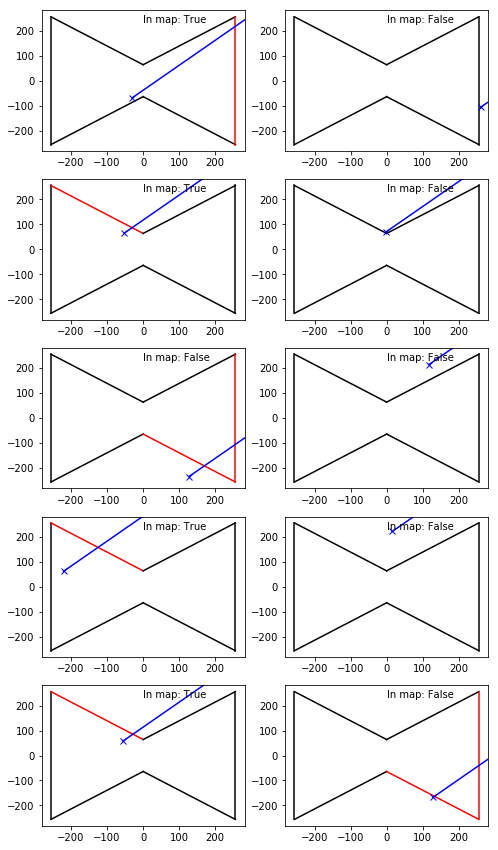

In [37]:
filename = "/home/james/Desktop/textmap.txt"
vertices, linedefs = parse_textmap(filename)
num_pts = 10
spawn_pts = (2 * np.random.rand(num_pts, 2) - 1) * 300
fig, ax = plt.subplots(num_pts // 2 + num_pts % 2, 2, figsize=(8,15))
max_val = np.max(abs(vertices))
for i, spawn_pt in enumerate(spawn_pts):
    j = i // 2
    k = i % 2
    ax[j][k].set_xlim([-1.1*max_val, 1.1*max_val])
    ax[j][k].set_ylim([-1.1*max_val, 1.1*max_val])
    intersects, x_i, on_vertex = find_intersections(spawn_pt, vertices=vertices, linedefs=linedefs)
    for intersect, linedef in zip(intersects, linedefs):
        x_1 = vertices[linedef[0]]
        x_2 = vertices[linedef[1]]
        if intersect:
            color = 'red'
        else:
            color = 'black'
        boundary = ax[j][k].plot([x_1[0], x_2[0]], [x_1[1], x_2[1]], color=color)
    
    spawn = ax[j][k].plot(spawn_pt[0], spawn_pt[1], 'x', color='b')
    ray_pt = spawn_pt + m_ray * max_val * 2
    ray = ax[j][k].plot([spawn_pt[0], ray_pt[0]], [spawn_pt[1], ray_pt[1]], color='b')
    
    in_map = ( (np.sum(intersects) - (on_vertex / 2)) % 2 == 1 )
    in_map = ax[j][k].text(0.0, 0.9*max_val, 'In map: %s' % str(in_map))

In [112]:
# Create string
x = -48.0
y = 0.0
for i, angle in enumerate(range(0, 360, 20)):
    s = \
"""thing//#%d
{
x=%.3f;
y=%.3f;
type=1;
angle=%d;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}\n""" % (i, x, y, angle)
    print(s)

thing//#0
{
x=-48.000;
y=0.000;
type=1;
angle=0;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}

thing//#1
{
x=-48.000;
y=0.000;
type=1;
angle=20;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}

thing//#2
{
x=-48.000;
y=0.000;
type=1;
angle=40;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}

thing//#3
{
x=-48.000;
y=0.000;
type=1;
angle=60;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}

thing//#4
{
x=-48.000;
y=0.000;
type=1;
angle=80;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}

thing//#5
{
x=-48.000;
y=0.000;
type=1;
angle=100;
coop=true;
dm=true;
single=true;
skill1=true;
skill2=true;
skill3=true;
skill4=true;
skill5=true;
}

thing//#6
{
x=-48.000;
y=0.000;
type=1;
angle=120;
coop=true;
dm=true;
single=true;
skill1=tru

## Inspecting tf checkpoint files

In [13]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

In [18]:
# print_tensors_in_checkpoint_file(filename, tensor_name, all_tensors)
print_tensors_in_checkpoint_file("../experiments/pretraining/trial_1/train_data/net_data/target_net/params/train_model-10", "", True)

tensor_name:  target_network/target_network/rnn/lstm_cell/weights/RMSProp_1
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
tensor_name:  target_network/target_network/rnn/lstm_cell/weights/RMSProp
[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
tensor_name:  target_network/target_network/rnn/lstm_cell/biases/RMSProp_1
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  

[ 0.09986898  0.10134434  0.09872764]
tensor_name:  target_network/target_network/CONV_1/weights/RMSProp
[[[[ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]]

  [[ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]]

  [[ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]]

  ..., 
  [[ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]]

  [[ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]]

  [[ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]]]


 [[[ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]]

  [[ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...,  1.  1.  1.]]

  [[ 1.  1.  1. ...,  1.  1.  1.]
   [ 1.  1.  1. ...

tensor_name:  main_network/main_network/FC_1/weights/RMSProp
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
tensor_name:  target_network/CONV_1/weights
[[[[ -4.33822116e-03   2.93216412e-03   8.27555452e-03 ...,
     -1.36828311e-02  -1.83154214e-02  -8.80464260e-03]
   [  8.61088093e-03  -1.78104290e-03   1.85854768e-03 ...,
     -5.19292383e-03  -1.62963779e-03  -5.22557227e-03]
   [  1.21164625e-03   1.63698080e-03  -7.53372302e-03 ...,
     -7.79376947e-04   1.68354111e-03   1.52571278e-03]]

  [[  6.64143125e-03  -3.75650381e-03   1.35315699e-03 ...,
     -3.75866657e-03   4.87121753e-03   1.26087777e-02]
   [  7.42718205e-03  -1.01067796e-02  -6.27987599e-03 ...,
     -7.76540535e-03   7.39574386e-03   9.55023430e-03]
   [ -5.79846883e-03   1.94430561e-03  -9.58230998e-03 ...,
     -2.50712899e-03  -5.22650592e-03  -3.85600119e-0